In [287]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import defaultdict

In [288]:
torch.manual_seed(1337)

In [289]:
#generate data for training as hidden state activations via LRH - sum of sparse overcomplete feature directions

def generate_hidden_data(dim = 128, n_features = 512, 
                         n_samples = (2**14), sparsity = 10):
    #basically want features Y times random vector w where w is sparse, then sum resulting vectors for hidden state
    #overcomplete feature basis?
    features = np.random.randn(n_features, dim)
    features = features / np.linalg.norm(features, axis=1, keepdims=True)

    #init sparsity weights
    weights = np.zeros((n_samples, n_features))
    #generate sparsity weights
    for i in tqdm(range(n_samples)):
        active_feats = np.random.choice(n_features, size=sparsity, replace=False)
        weights[i, active_feats] = np.random.randn(sparsity)
    #make hidden data via sum of sparse features
    hidden_data = weights @ features

    return torch.tensor(hidden_data, dtype=torch.float32)

In [290]:
class SAE(nn.Module):
    def __init__(self, input_dim, width_ratio=4, activation=nn.ReLU()):
        super().__init__()
        self.sae_hidden = input_dim * width_ratio
        self.W_in = nn.Parameter(
            nn.init.kaiming_uniform_(
                torch.empty(input_dim, self.sae_hidden), nonlinearity="relu"
            )
        )
        self.b_in = nn.Parameter(torch.zeros(self.sae_hidden))
        self.W_out = nn.Parameter(
            nn.init.kaiming_uniform_(
                torch.empty(self.sae_hidden, input_dim), nonlinearity="relu"
            )
        )
        self.b_out = nn.Parameter(torch.zeros(input_dim))
        self.nonlinearity = activation

    def _normalize_weights(self):
        with torch.no_grad():
            norms = self.W_out.norm(p=2, dim=0, keepdim=True)
            self.W_out.div_(norms)

    def forward(self, x):
        x = x - self.b_out
        acts = self.nonlinearity(x @ self.W_in + self.b_in)
        l1_regularization = acts.abs().sum()
        l0 = (acts > 0).sum(dim=1).float().mean()
        self._normalize_weights()

        return l0, l1_regularization, acts@self.W_out + self.b_out


In [291]:
def train(model, train_data, test_data, batch_size=128, n_epochs=1000, l1_lam=3e-5, weight_decay=1e-4):
    optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)
    mse_criterion = nn.MSELoss()

    n_batches = len(train_data) // batch_size
    n_test_batches = len(test_data) // batch_size

    for epoch in range(n_epochs):
        total_loss = 0
        total_test_loss = 0
        total_mse_loss = 0
        total_l1_loss = 0
        total_l0 = 0
        batch_perm = torch.randperm(len(train_data))
        test_batch_perm = torch.randperm(len(test_data))

        for i in range(n_batches):
            # training
            idx = batch_perm[i*batch_size: (i+1)*batch_size]
            batch = train_data[idx]

            optimizer.zero_grad()
            l0, l1, recon_hiddens = model(batch)

            recon_loss = mse_criterion(recon_hiddens, batch)
            sparsity_loss = l1_lam * l1
            loss = recon_loss + sparsity_loss

            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            total_l1_loss += sparsity_loss.item()
            total_mse_loss += recon_loss.item()
            total_l0 += l0

            # testing
            if i < n_test_batches:
                test_idx = test_batch_perm[i*batch_size: (i+1)*batch_size]
                test_batch = test_data[test_idx]
                
                with torch.no_grad():
                    _, _, test_recon = model(test_batch)
                    test_loss = mse_criterion(test_recon, test_batch)
                    total_test_loss += test_loss.item()

        """ if epoch % 10 == 0:
            avg_loss = total_loss / n_batches
            avg_test_loss = total_test_loss / n_test_batches
            avg_l1_loss = total_l1_loss / n_batches
            avg_l0 = total_l0 / n_batches
            
            print(f'Epoch {epoch}, Loss: {avg_loss:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, '
                  f'L1: {avg_l1_loss:.4f}, '
                  f'L0: {avg_l0:.4f}') """

    return {
        'mse': total_mse_loss/n_batches,
        'L0': total_l0/n_batches,
        'L1 lambda': l1_lam,
    }

In [292]:
def run_experiment():
    sparsity = 50
    hidden_dim = 128
    width_factor = 4

    data = generate_hidden_data(dim=hidden_dim, sparsity=sparsity)
    train_size = int(0.8 * len(data))
    train_data, test_data = data[:train_size], data[train_size:]
    
    relu_model = SAE(hidden_dim, width_factor, nn.ReLU())
    print("Training ReLU model...")
    result = train(relu_model, train_data, test_data)
            

def run_DOE():
    sparsities = [5, 10, 20, 30, 40, 50]
    l1_lams = [2e-5, 3e-5, 4e-5, 5e-5, 6e-5]
    seeds = [1337, 42, 69, 420, 666]
    hidden_dim = 128
    results = defaultdict(list)
    width_factor = 4

    for sparsity in tqdm(sparsities):
        for l1_lam in tqdm(l1_lams):
            data = generate_hidden_data(dim=hidden_dim, sparsity=sparsity)
            
            # shuffle data
            indices = torch.randperm(len(data))
            data = data[indices]
            
            # split into train/test
            train_size = int(0.8 * len(data))
            train_data, test_data = data[:train_size], data[train_size:]
            
            relu_model = SAE(hidden_dim, width_factor, nn.ReLU())
            print(f"Training ReLU model with {sparsity} sparsity")
            results[sparsity].append(train(relu_model, train_data, test_data, l1_lam=l1_lam))

    return results
            

In [293]:
results = run_DOE()

  0%|          | 0/6 [00:00<?, ?it/s]


100%|██████████| 16384/16384 [00:00<00:00, 78995.17it/s]


Training ReLU model with 5 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 71102.70it/s]


Training ReLU model with 5 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 66824.08it/s]


Training ReLU model with 5 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 65470.81it/s]


Training ReLU model with 5 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 62648.46it/s]


Training ReLU model with 5 sparsity


 17%|█▋        | 1/6 [10:00<50:02, 600.47s/it]


100%|██████████| 16384/16384 [00:00<00:00, 63629.20it/s]


Training ReLU model with 10 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 65062.39it/s]


Training ReLU model with 10 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 65137.62it/s]


Training ReLU model with 10 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 63117.08it/s]


Training ReLU model with 10 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 60392.02it/s]


Training ReLU model with 10 sparsity


 33%|███▎      | 2/6 [20:47<41:52, 628.06s/it]


100%|██████████| 16384/16384 [00:00<00:00, 63210.55it/s]


Training ReLU model with 20 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 61783.53it/s]


Training ReLU model with 20 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 58870.30it/s]


Training ReLU model with 20 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 57180.60it/s]


Training ReLU model with 20 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 56033.63it/s]


Training ReLU model with 20 sparsity


 50%|█████     | 3/6 [32:33<33:10, 663.42s/it]


100%|██████████| 16384/16384 [00:00<00:00, 56455.11it/s]


Training ReLU model with 30 sparsity






100%|██████████| 16384/16384 [00:00<00:00, 50426.43it/s]


Training ReLU model with 30 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 59007.59it/s]


Training ReLU model with 30 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 55657.32it/s]


Training ReLU model with 30 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 57103.39it/s]


Training ReLU model with 30 sparsity


 67%|██████▋   | 4/6 [44:09<22:32, 676.49s/it]



100%|██████████| 16384/16384 [00:00<00:00, 51933.52it/s]


Training ReLU model with 40 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 59409.73it/s]


Training ReLU model with 40 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 58908.40it/s]


Training ReLU model with 40 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 59961.45it/s]


Training ReLU model with 40 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 59266.12it/s]


Training ReLU model with 40 sparsity


 83%|████████▎ | 5/6 [54:15<10:50, 650.85s/it]


100%|██████████| 16384/16384 [00:00<00:00, 58785.79it/s]


Training ReLU model with 50 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 59949.42it/s]


Training ReLU model with 50 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 64867.82it/s]


Training ReLU model with 50 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 76004.26it/s]


Training ReLU model with 50 sparsity





100%|██████████| 16384/16384 [00:00<00:00, 71032.51it/s]


Training ReLU model with 50 sparsity


100%|██████████| 6/6 [2:16:15<00:00, 1362.57s/it]


In [294]:
import pandas as pd

# First, let's flatten the structure
flattened_data = []
for key, value_list in results.items():
    for item in value_list:
        # Create a row by combining the outer key with the inner dictionary
        row = {'sparsity': key, **item}
        flattened_data.append(row)

# Create DataFrame
df = pd.DataFrame(flattened_data)

# Convert tensor values to float if needed
if 'L0' in df.columns:
    df['L0'] = df['L0'].apply(lambda x: float(x))

In [295]:
df.head()

,sparsity,mse,L0,L1 lambda
0,5,0.022888,27.778952,0.00002
1,5,0.030227,13.400429,0.00003
2,5,0.033669,9.180377,0.00004
3,5,0.036639,6.129136,0.00005
4,5,0.038080,2.744409,0.00006


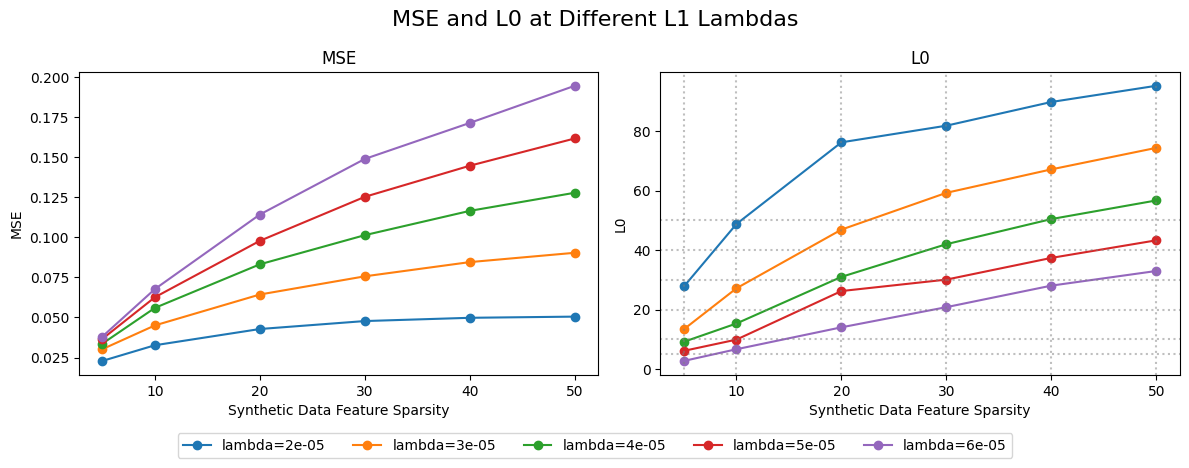

In [296]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
lambdas = df['L1 lambda'].unique()

# Create plots
for lam in lambdas:
    sub_df = df[df['L1 lambda'] == lam]
    ax[0].plot(sub_df['sparsity'], sub_df['mse'], marker='o', label=f'lambda={lam}')
    ax[1].plot(sub_df['sparsity'], sub_df['L0'], marker='o')

# Add reference lines for L0 values
l0_values = [5, 10, 20, 30, 40, 50]
for l0 in l0_values:
    # Horizontal line
    ax[1].axhline(y=l0, color='gray', linestyle=':', alpha=0.5)
    # Vertical line
    ax[1].axvline(x=l0, color='gray', linestyle=':', alpha=0.5)

# Add titles and labels
fig.suptitle('MSE and L0 at Different L1 Lambdas', fontsize=16)
ax[0].set_title('MSE')
ax[1].set_title('L0')
ax[0].set_xlabel('Synthetic Data Feature Sparsity')
ax[1].set_xlabel('Synthetic Data Feature Sparsity')
ax[0].set_ylabel('MSE')
ax[1].set_ylabel('L0')

# Adjust subplot spacing to make room for legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)

# Add single legend below both subplots
lines, labels = ax[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, 0),
          ncol=5, borderaxespad=3)

plt.show()